In [2]:
from google.colab import drive
drive.mount("/gdrive")
%cd /gdrive

Mounted at /gdrive
/gdrive


In [3]:
import os
os.chdir("/gdrive/My Drive/Colab Notebooks/Duygu_Tanima")

In [4]:
!ls

example_submission.csv	face_model.h5	 fer2013      icml_face_data.csv      test.csv
face_embs.npy		face_model.json  fer2013.tar  metadata_processed.csv


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint

In [6]:
data = pd.read_csv("/gdrive/My Drive/Colab Notebooks/Duygu_Tanima/fer2013/fer2013.csv")
print(data.shape)

(35887, 3)


In [7]:
print(data.info)

<bound method DataFrame.info of        emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 col

In [8]:
print(data["Usage"].value_counts())

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64


In [9]:
train_data = data[data.Usage == "Training"]

In [10]:
train_piksels = train_data.pixels.str.split(" ").tolist()

train_piksels = pd.DataFrame(train_piksels, dtype=int)
train_images = train_piksels.values
train_images = train_images.astype(np.float)

print(train_images)


<ipython-input-10-b813aabce951>:3: FutureWarning: Could not cast to int64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  train_piksels = pd.DataFrame(train_piksels, dtype=int)
<ipython-input-10-b813aabce951>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_images = train_images.astype(np.float)


[[ 70.  80.  82. ... 106. 109.  82.]
 [151. 150. 147. ... 193. 183. 184.]
 [231. 212. 156. ...  88. 110. 152.]
 ...
 [ 74.  81.  87. ... 188. 187. 187.]
 [222. 227. 203. ... 136. 136. 134.]
 [195. 199. 205. ...   6.  15.  38.]]


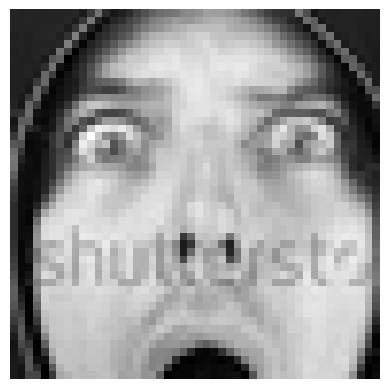

In [11]:
def show(img):
  show_image = img.reshape(48,48)
  plt.axis("off")
  plt.imshow(show_image, cmap="gray")

show(train_images[78])

In [12]:
train_labels = train_data["emotion"].values.ravel()

print(np.unique(train_labels))

[0 1 2 3 4 5 6]


In [13]:
def one_hot_encode(labels):

    num_classes = np.max(labels) + 1

    num_samples = len(labels)
    one_hot_encoded = np.zeros((num_samples, num_classes))

    for i, label in enumerate(labels):
        one_hot_encoded[i, label] = 1

    return one_hot_encoded


In [14]:
y_train = one_hot_encode(train_labels)
print(y_train)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [15]:
test_data = data[data.Usage == "PublicTest"]

In [16]:
test_piksels = test_data.pixels.str.split(" ").tolist()

test_piksels = pd.DataFrame(test_piksels, dtype=int)
test_images = test_piksels.values
test_images = test_images.astype(np.float)

print(test_images)

<ipython-input-16-75e12393fea7>:3: FutureWarning: Could not cast to int64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  test_piksels = pd.DataFrame(test_piksels, dtype=int)


[[254. 254. 254. ...  42. 129. 180.]
 [156. 184. 198. ... 172. 167. 161.]
 [ 69. 118.  61. ...  88.  87.  90.]
 ...
 [255. 255. 255. ...  48.  50.  46.]
 [ 33.  25.  31. ...   4.   5.   4.]
 [ 61.  63.  59. ... 113. 165. 180.]]


<ipython-input-16-75e12393fea7>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_images = test_images.astype(np.float)


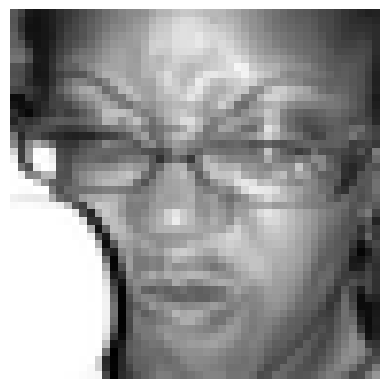

In [17]:
show(test_images[122])

In [18]:
test_labels = test_data["emotion"].values.ravel()

print(np.unique(test_labels))

[0 1 2 3 4 5 6]


In [19]:
y_test = one_hot_encode(test_labels)
print(y_test)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


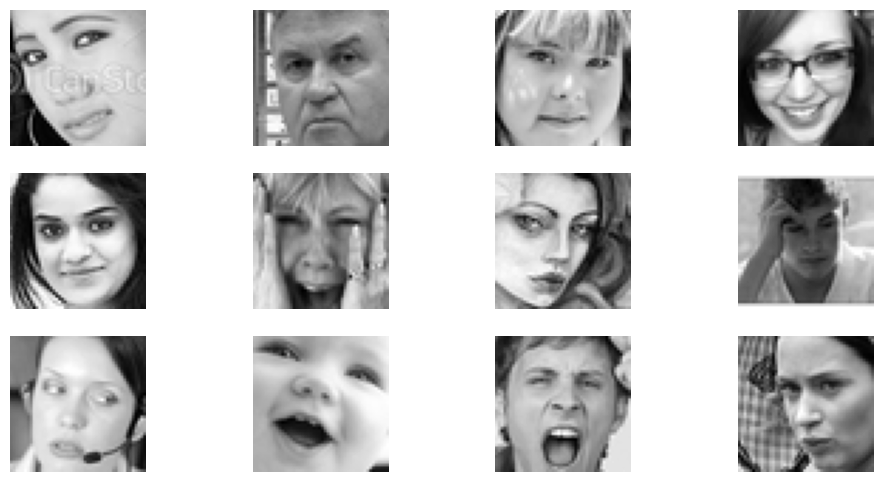

In [20]:
plt.figure(0,figsize=(12,6))
for i in range(1,13):
  plt.subplot(3,4,i)
  plt.axis("off")

  image = test_images[i].reshape(48,48)
  plt.imshow(image, cmap="gray")
plt.show()

In [21]:
#cnn

model = Sequential()

model.add(Conv2D(64, 3, data_format="channels_last", input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.6))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.6))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.6))

model.add(Dense(7))
model.add(Activation("softmax"))

In [22]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 46, 46, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 44, 44, 64)        256       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 44, 44, 64)        0

In [23]:
x_train = train_images.reshape(-1, 48, 48, 1)
x_test = test_images.reshape(-1, 48, 48, 1)
print(x_train.shape)

(28709, 48, 48, 1)


In [24]:
checkpointer = ModelCheckpoint("/gdrive/My Drive/Colab Notebooks/Duygu_Tanima/face_model.h5", verbose=1, save_best_only=True)

epochs=20
batchSize=100

hist = model.fit(x_train,y_train,
                 epochs=epochs,
                 shuffle=True,
                 batch_size=batchSize,
                 validation_data = (x_test,y_test),
                 callbacks=[checkpointer],verbose=2)

model_json = model.to_json()
with open("/gdrive/My Drive/Colab Notebooks/Duygu_Tanima/face_model.json", "w") as json_file:
  json_file.write(model_json)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.62403, saving model to /gdrive/My Drive/Colab Notebooks/Duygu_Tanima/face_model.h5
288/288 - 613s - loss: 1.9963 - accuracy: 0.2495 - val_loss: 1.6240 - val_accuracy: 0.3784 - 613s/epoch - 2s/step
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.62403 to 1.56117, saving model to /gdrive/My Drive/Colab Notebooks/Duygu_Tanima/face_model.h5
288/288 - 560s - loss: 1.6503 - accuracy: 0.3493 - val_loss: 1.5612 - val_accuracy: 0.4035 - 560s/epoch - 2s/step
Epoch 3/20

Epoch 3: val_loss improved from 1.56117 to 1.47516, saving model to /gdrive/My Drive/Colab Notebooks/Duygu_Tanima/face_model.h5
288/288 - 628s - loss: 1.5389 - accuracy: 0.3990 - val_loss: 1.4752 - val_accuracy: 0.4310 - 628s/epoch - 2s/step
Epoch 4/20

Epoch 4: val_loss did not improve from 1.47516
288/288 - 672s - loss: 1.4641 - accuracy: 0.4335 - val_loss: 1.5125 - val_accuracy: 0.4113 - 672s/epoch - 2s/step
Epoch 5/20

Epoch 5: val_loss improved from 1.47516 to 1.35257, saving model to /gdrive/My Drive/Colab Notebooks/Duygu_Tanima/face_model.h5
288/288 - 534s - loss: 1.4110 - accuracy: 0.4529 - val_loss: 1.3526 - val_accuracy: 0.4820 - 534s/epoch - 2s/step
Epoch 6/20

Epoch 6: val_loss did not improve from 1.35257
288/288 - 526s - 

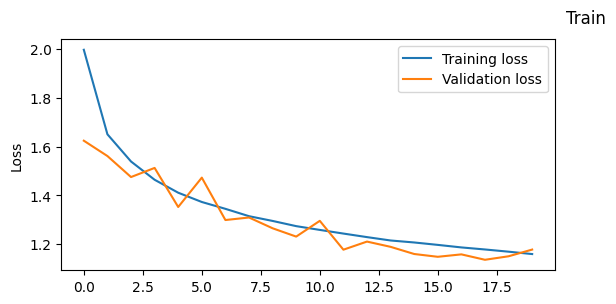

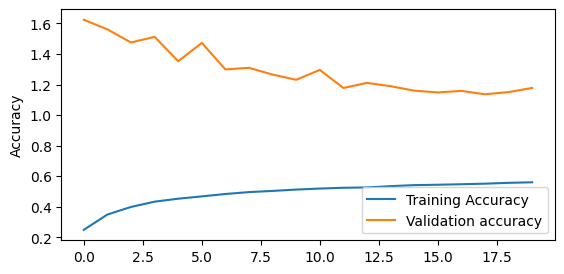

In [25]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,1)
plt.ylabel("Loss")
plt.suptitle("Train")
plt.plot(hist.history["loss"],label="Training loss")
plt.plot(hist.history["val_loss"],label="Validation loss")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(14,3))
plt.subplot(1,2,1)
plt.ylabel("Accuracy")
plt.plot(hist.history["accuracy"],label="Training Accuracy")
plt.plot(hist.history["val_loss"],label="Validation accuracy")
plt.legend(loc="lower right")
plt.show()

In [38]:
test = data[["emotion","pixels"]][data.Usage == "PrivateTest"]
test["pixels"] = test["pixels"].apply(lambda im: np.fromstring(im, sep=" "))
#test["pixels"] = test["pixels"].str.split(" ").tolist()

print(test.head())

       emotion                                             pixels
32298        0  [170.0, 118.0, 101.0, 88.0, 88.0, 75.0, 78.0, ...
32299        5  [7.0, 5.0, 8.0, 6.0, 7.0, 3.0, 2.0, 6.0, 5.0, ...
32300        6  [232.0, 240.0, 241.0, 239.0, 237.0, 235.0, 246...
32301        4  [200.0, 197.0, 149.0, 139.0, 156.0, 89.0, 111....
32302        2  [40.0, 28.0, 33.0, 56.0, 45.0, 33.0, 31.0, 78....


In [39]:
x_test_private = np.vstack(test["pixels"].values)
y_test_private = np.array(test["emotion"])

In [40]:
from keras.utils import to_categorical
x_test_private = x_test_private.reshape(-1, 48, 48, 1)
y_test_private =  to_categorical(y_test_private)
#y_test = one_hot_encode(test_labels)
print(x_test_private.shape)

(3589, 48, 48, 1)


In [41]:
score = model.evaluate(x_test_private, y_test_private, verbose=0)
print(score)

[1.1759573221206665, 0.5519643425941467]


In [42]:
#test
from keras.models import load_model
from PIL import Image
from keras.preprocessing import image

In [43]:
model_best = load_model("/gdrive/My Drive/Colab Notebooks/Duygu_Tanima/face_model.h5")

In [44]:
os.chdir("/gdrive/My Drive/Colab Notebooks/Duygu_Tanima")
!ls

example_submission.csv	face_model.json  icml_face_data.csv  metadata_processed.csv
face_embs.npy		fer2013		 insan1.jpeg	     test.csv
face_model.h5		fer2013.tar	 insan2.jpeg


In [49]:
image_path = "/gdrive/My Drive/Colab Notebooks/Duygu_Tanima/insan2.jpeg"

test_image_original = image.load_img(image_path)

test_image = image.load_img(image_path, target_size=(48,48), grayscale=True)
test_data = image.img_to_array(test_image)

test_data = np.expand_dims(test_data, axis=0)
test_data = np.vstack([test_data])

results = model_best.predict(test_data, batch_size=1)
results

1/1 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


array([[0.07206354, 0.00769704, 0.30423993, 0.03727586, 0.3548685 ,
        0.05727591, 0.16657922]], dtype=float32)

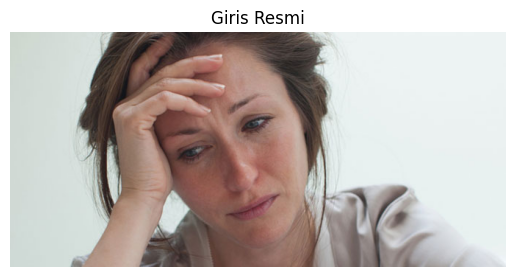

uzgun


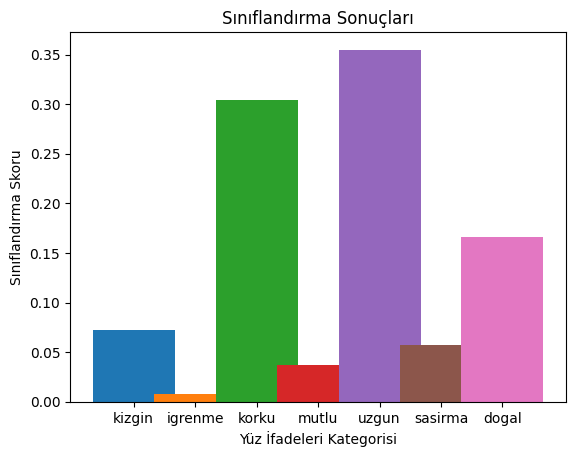

In [50]:
class_names = ["kizgin", "igrenme", "korku", "mutlu", "uzgun", "sasirma", "dogal"]

ind = 0.1 + 0.6*np.arange(len(class_names))

plt.imshow(test_image_original)
plt.title("Giris Resmi")
plt.axis("off")
plt.show()
print(class_names[np.argmax(results)])

for i in range(len(class_names)):
  plt.bar(ind[i], results[0][i])


plt.title("Sınıflandırma Sonuçları")
plt.xlabel("Yüz İfadeleri Kategorisi")
plt.ylabel("Sınıflandırma Skoru")
plt.xticks(ind,class_names)
plt.show()
